# Create Your Own Cognitive Portrait
## Technique: Circular Faces

Hello! Let's create some **Science Art** together with this **Cogntivie Portrait** challenge!

This is short notebook with mostly the code, you can view more detailed instructions in `CognitivePortrait.ipynb`.

In [5]:
import sys
!{sys.executable} -m pip install --quiet --user -r requirements.txt
import cv2
import matplotlib.pyplot as plt
import glob, os

Obtain the Face API Key in one of the following ways:

* Request 7 days trial key [here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&wt.mc_id=aiapril-github-dmitryso).
* If you have an Azure Subscription - [create Cognitive Services resource](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account/?wt.mc_id=aiapril-github-dmitryso), and grab key/url from there
* [Create free trial subscription](https://azure.microsoft.com/free/?wt.mc_id=aiapril-github-dmitryso) and follow previous step

**Important:** If you use trial key, your Face API will have some limitations, in terms of number of images you can process, and frequency of API calls (not more than 20 calls per minute). In order to make things work, we would need to insert some pauses in between calls, when using API on a series of images.

After you get the key and endpoint, please insert them into the cell below. There would typically be two keys given on the portal, you can use any one of them.

In [6]:
key = '--INSERT YOUR KEY HERE--'
endpoint = 'https://westus2.api.cognitive.microsoft.com' 
# You might need different endpoint, check the cognitive services page!

In [7]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

## Getting Some Images

In this repository, sample images of Bill Gates are available in  `images/gates` directory. You can upload your own images using Azure Notebooks file upload feature. I suggest you create some other directory inside `images` for that purpose. Specify the directory name in the variable below:

In [8]:
path = 'images/gates/*'

For our further experiments, let's load all images, and run them through Face API to obtain facial landmarks. We will save the images into `images` array, and landmarks data into `imagepoints`.
NOTE: If you have trial API, you may run out of allowed request-per-minute. In this case, add delay to the processing loop.

In [9]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fnames = glob.glob(path)

filenames = []
images = []
imagepoints = []
cli.face.detect_with_url('https://soshnikov.com/images/official/shwars_geek.jpg')
for fn in fnames:
    print("Processing {}".format(fn))
    with open(fn,'rb') as f:
        res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())

Processing images/gates\gates_0.jpg
Processing images/gates\gates_1.jpg
Processing images/gates\gates_10.jpg
Processing images/gates\gates_11.jpg
Processing images/gates\gates_12.jpg
Processing images/gates\gates_13.jpg
Processing images/gates\gates_14.jpg
Processing images/gates\gates_15.jpg
Processing images/gates\gates_16.jpg
Processing images/gates\gates_17.jpg
Processing images/gates\gates_19.jpg
Processing images/gates\gates_2.jpg
Processing images/gates\gates_21.jpg
Processing images/gates\gates_22.jpg
Processing images/gates\gates_23.jpg
Processing images/gates\gates_24.jpg
Processing images/gates\gates_25.jpg
Processing images/gates\gates_26.jpg
Processing images/gates\gates_27.jpg
Processing images/gates\gates_28.jpg
Processing images/gates\gates_29.jpg
Processing images/gates\gates_3.jpg
Processing images/gates\gates_30.jpg
Processing images/gates\gates_31.jpg
Processing images/gates\gates_33.jpg
Processing images/gates\gates_34.jpg
Processing images/gates\gates_35.jpg
Proce

## Affine Transformations

We want to layout all eyes on a circle, in `n_ppl` different positions. `triangles` is the array of triangle coordinates, which are calculated using some simple trigonometry.

In [41]:
from math import sin,cos,pi
import numpy as np

width = 2000
height = 2000
radius = 800
n_ppl = 6
da = 2*pi/360*5

def get_tri(i):
    a = i*2*pi/n_ppl
    x1 = width/2+radius*cos(a-da)
    y1 = height/2+radius*sin(a-da)
    x2 = width/2+radius*cos(a+da)
    y2 = height/2+radius*sin(a+da)
    x3 = width/2+(radius-150)*cos(a)
    y3 = height/2+(radius-150)*sin(a)
    return [(x1,y1),(x2,y2),(x3,y3)]

triangles = [ get_tri(i) for i in range(n_ppl)]

def get_transform(f,flag):
    flag = min(flag,len(triangles)-1)
    mc_x = (f['mouth_left']['x']+f['mouth_right']['x'])/2.0
    mc_y = (f['mouth_left']['y'] + f['mouth_right']['y']) / 2.0
    return cv2.getAffineTransform(np.float32([(f['pupil_left']['x'],f['pupil_left']['y']),(f['pupil_right']['x'],f['pupil_right']['y']),(mc_x,mc_y)]),
                                np.float32(triangles[flag]))

def transform(img,pts,flag):
    tr = get_transform(pts,flag)
    return cv2.warpAffine(img,tr,(width,height))

In [42]:
img_aligned = [transform(i,a,n%n_ppl) for i,a,n in zip(images,imagepoints,range(len(images)))]

## Image Blending

To blend images together, we use clevel merging with some image normalization:

In [43]:
def merge(images,wts=None,normalize=True):
    images = list(images)
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    if normalize:
        mi = res.min()
        ma = res.max()
        res = 255.0*(res-mi)/(ma-mi)
    return res.astype(np.ubyte)

Now let's merge all aligned images altogether and see what happens:

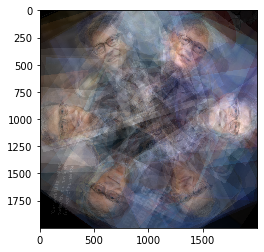

In [44]:
res = merge(img_aligned)
plt.imshow(res)

## Saving the result

I recommend to save the result into `results` directory, and to add quick description of the technique you used into `readme.md` file in the repo. To save the image, please execute the cell below:

In [40]:
cv2.imwrite('results/gates_res.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True